<a href="https://colab.research.google.com/github/mirchandani-mohnish/ClusterMetrics/blob/main/Affinity_Propogation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
from sklearn import datasets
import matplotlib.pyplot as plt
import kagglehub
import pandas as pd
import os
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, calinski_harabasz_score, davies_bouldin_score, mutual_info_score
from sklearn.preprocessing import StandardScaler
import time
from sklearn.decomposition import PCA
import heapq
from scipy.spatial.distance import euclidean
from sklearn.cluster import AffinityPropagation
import kagglehub
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.metrics.pairwise import euclidean_distances

In [9]:
seed = 0

In [10]:

def print_metrics(X, true_labels_values, predicted_labels):
    print("-------------------------------------------------------------------")
    true_labels = LabelEncoder().fit_transform(true_labels_values)
    # Silhouette Score
    try:
        print(f"Silhouette score: {silhouette_score(X, predicted_labels):.4f}")
    except Exception as e:
        print(f"Silhouette score failed: {str(e)}")

    # Adjusted Rand Score
    try:
        print(f"Adjusted Rand score: {adjusted_rand_score(true_labels, predicted_labels):.4f}")
    except Exception as e:
        print(f"Adjusted Rand score failed: {str(e)}")

    # Calinski-Harabasz Score
    try:
        print(f"Calinski-Harabasz score: {calinski_harabasz_score(X, predicted_labels):.4f}")
    except Exception as e:
        print(f"Calinski-Harabasz score failed: {str(e)}")

    # Davies-Bouldin Score
    try:
        print(f"Davies-Bouldin score: {davies_bouldin_score(X, predicted_labels):.4f}")
    except Exception as e:
        print(f"Davies-Bouldin score failed: {str(e)}")

    # Mutual Information Score
    try:
        print(f"Mutual Information score: {mutual_info_score(true_labels, predicted_labels):.4f}")
    except Exception as e:
        print(f"Mutual Information score failed: {str(e)}")


# Affinity Propogation



In [11]:
class AffinityPropagationCustom:
    def __init__(self, damping=0.5, max_iter=300, conv_iter=15, preference=None):
        self.damping = damping
        self.max_iter = max_iter
        self.conv_iter = conv_iter
        self.preference = preference

    def fit(self, X):
        n = X.shape[0]
        S = -euclidean_distances(X, squared=True)
        A = np.zeros((n, n))
        R = np.zeros((n, n))
        if self.preference is None:
            self.preference = np.median(S)
        np.fill_diagonal(S, self.preference)
        for iter in range(self.max_iter):
            R_old = R.copy()
            A_old = A.copy()
            AS = A + S
            max_S = np.partition(AS, -2, axis=1)[:, -2]
            R = S - max_S[:, np.newaxis]
            R = (1 - self.damping) * R + self.damping * R_old
            R_pos = np.maximum(0, R)
            np.fill_diagonal(R_pos, 0)
            A_new = np.minimum(0, R + np.sum(R_pos, axis=0, keepdims=True))
            np.fill_diagonal(A_new, np.sum(R_pos, axis=0))
            A = (1 - self.damping) * A_new + self.damping * A_old
            if np.allclose(R, R_old) and np.allclose(A, A_old):
                break
        exemplars = np.argmax(A + R, axis=1)
        unique_exemplars = np.unique(exemplars)
        cluster_map = {exemplar: idx for idx, exemplar in enumerate(unique_exemplars)}
        labels = np.array([cluster_map[exemplars[i]] for i in range(n)])
        self.labels_ = labels
        self.exemplars_ = unique_exemplars
        return self

## Iris Dataset

In [12]:
path = kagglehub.dataset_download("himanshunakrani/iris-dataset")
iris = pd.read_csv(os.path.join(path, "iris.csv"))
iris = iris.dropna()

iris_filtered = iris.select_dtypes(include=['float64'])

X_iris = iris_filtered.to_numpy()


start_time = time.time()
affinityProp = AffinityPropagationCustom().fit(X_iris)

labels_base_iris = affinityProp.labels_
print(labels_base_iris)
print(f"Execution time (base): {time.time() - start_time} seconds")
# print(f"Silhouette score (base): {silhouette_score(X_iris, labels_base_iris)}")
print_metrics(X_iris, iris['species'], labels_base_iris)

start_time = time.time()
affinity_prop_iris = AffinityPropagation().fit(X_iris)

labels_sklearn_iris = affinity_prop_iris.labels_
print(labels_sklearn_iris)

print(f"\nExecution time (sklearn): {time.time() - start_time} seconds")
print_metrics(X_iris, iris['species'], labels_sklearn_iris)

[11 10 28 28  0 12 28 26 25 24 29  5  1 25 23 23  8  0  3 15 21 13  4 17
  9  7 16 18  0 20 19 14 23 22  7 30  8  7  6  5 11  6 25 17 27  1 13  2
  8  5 33 36 31 52 38 41 32 55 35 52 55 58 54 53 48 45 50 54 51 46 84 59
 72 39 59 40 38 33 53 47 47 46 54 81 41 36 33 42 57 34 56 39 48 37 60 58
 57 44 37 58 82 88 73 67 80 71 50 78 76 89 92 92 85 61 70 93 83 79 71 43
 89 61 63 74 69 77 72 84 80 73 64 68 76 49 62 78 93 67 75 66 90 91 61 69
 86 87 72 65 82 75]
Execution time (base): 0.02505207061767578 seconds
-------------------------------------------------------------------
Silhouette score: -0.1774
Adjusted Rand score: 0.0225
Calinski-Harabasz score: 80.3907
Davies-Bouldin score: 1.3567
Mutual Information score: 1.0674
[1 0 0 0 1 1 0 0 0 0 1 0 0 0 1 1 1 1 1 1 1 1 0 1 0 0 1 1 1 0 0 1 1 1 0 0 1
 0 0 1 1 0 0 1 1 0 1 0 1 0 2 2 2 3 2 3 2 3 2 3 3 2 3 2 3 2 4 3 2 3 4 3 4 2
 2 2 2 2 2 3 3 3 3 4 3 2 2 2 3 3 3 2 3 3 3 3 3 2 3 3 6 4 6 6 6 5 3 5 6 5 6
 4 6 4 4 6 6 5 5 4 6 4 5 4 6 6 4 4 6 6 5 5 6 4 4 

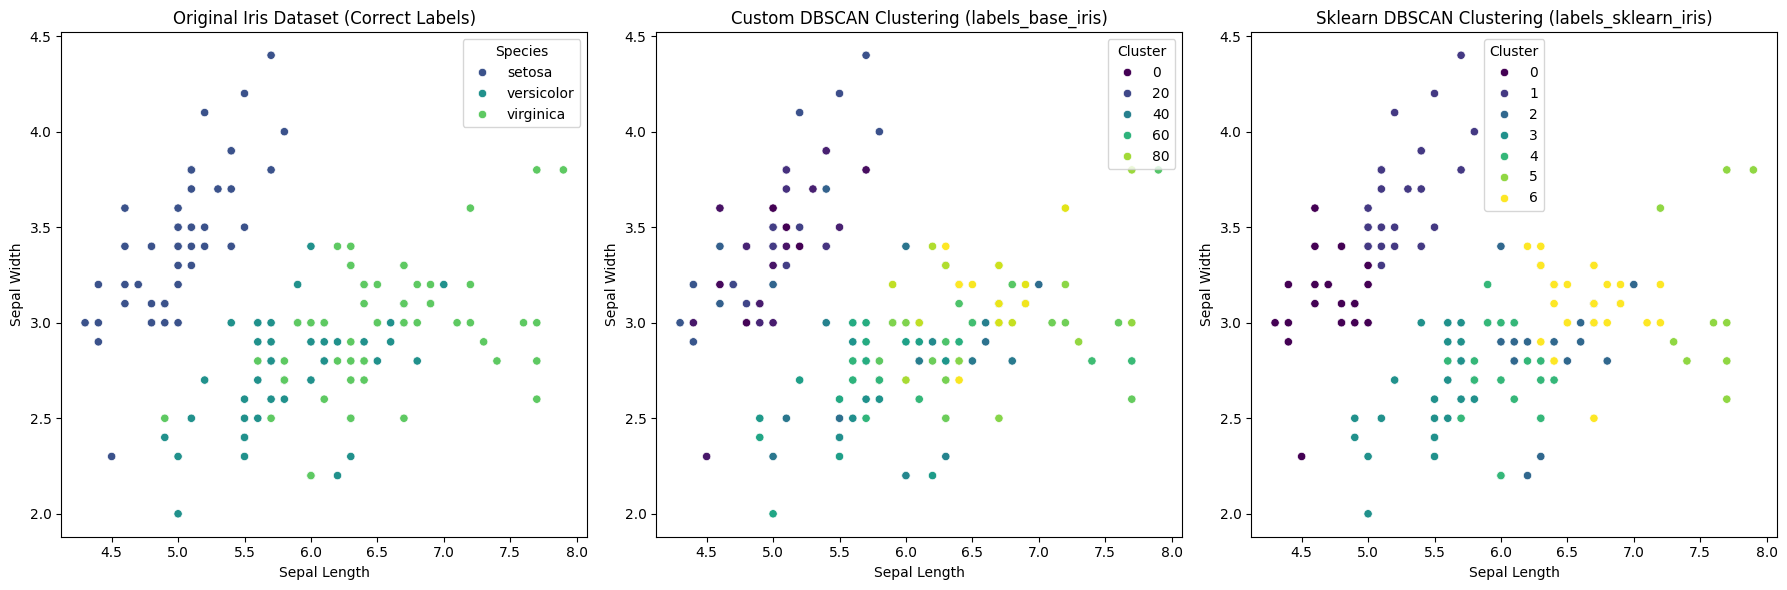

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Original Iris Dataset with Correct Labels
sns.scatterplot(data=iris, x="sepal_length", y="sepal_width", hue="species", palette="viridis", ax=axes[0])
axes[0].set_title("Original Iris Dataset (Correct Labels)")
axes[0].set_xlabel("Sepal Length")
axes[0].set_ylabel("Sepal Width")
axes[0].legend(title="Species")

# Plot 2: Custom DBSCAN Labels (labels_base_iris)
sns.scatterplot(data=iris, x="sepal_length", y="sepal_width", hue=labels_base_iris, palette="viridis", ax=axes[1])
axes[1].set_title("Custom DBSCAN Clustering (labels_base_iris)")
axes[1].set_xlabel("Sepal Length")
axes[1].set_ylabel("Sepal Width")
axes[1].legend(title="Cluster")

# Plot 3: Sklearn DBSCAN Labels (labels_sklearn_iris)
sns.scatterplot(data=iris, x="sepal_length", y="sepal_width", hue=labels_sklearn_iris, palette="viridis", ax=axes[2])
axes[2].set_title("Sklearn DBSCAN Clustering (labels_sklearn_iris)")
axes[2].set_xlabel("Sepal Length")
axes[2].set_ylabel("Sepal Width")
axes[2].legend(title="Cluster")

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

## AI Dataset


In [14]:
path = kagglehub.dataset_download("katerynameleshenko/ai-index")
ai = pd.read_csv(os.path.join(path, "AI_index_db.csv"))
ai = ai.dropna()

ai["Total_score_Category"] = pd.cut(
    ai["Total score"],
    bins=[-float("inf"), 17.03, 26.91, float("inf")],
    labels=["Low", "Medium", "High"]
)
ai = ai.drop(columns=["Total score", "Country"])

ai_filtered = ai.drop(columns=["Total_score_Category"])

encoder = OrdinalEncoder()

categorical_cols = [col for col in ai_filtered.columns if ai_filtered[col].dtype not in [np.int64, np.float64]]
ai_filtered[categorical_cols] = encoder.fit_transform(ai_filtered[categorical_cols])

X_ai = ai_filtered.to_numpy()

scalar = StandardScaler()
X_ai = scalar.fit_transform(X_ai)

print("AI Global Index")

start_time = time.time()
# labels_base_ai, centroids_base_ai = k_means(X_ai, k_ai)
affinity_prop = AffinityPropagationCustom().fit(X_ai)

labels_base_ai = affinity_prop.labels_
print(labels_base_ai)
print(f"Execution time (base): {time.time() - start_time} seconds")
# print(f"Silhouette score (base): {silhouette_score(X_ai, labels_base_ai)}")
print_metrics(X_ai, ai['Total_score_Category'], labels_base_ai)
start_time = time.time()


affinity_prop_sklearn = AffinityPropagation().fit(X_ai)

labels_sklearn_ai = affinity_prop_sklearn.labels_

print(f"\nExecution time (sklearn): {time.time() - start_time} seconds")
print_metrics(X_ai, ai['Total_score_Category'], labels_sklearn_ai)

100%|██████████| 2.38k/2.38k [00:00<00:00, 745kB/s]

Extracting files...
AI Global Index
[ 0  1  4  5  2  6  6  7  5  4 10  3  9  8 11  6 12 11 16 13  8 20 19 16
 24 21 19 18 17 19 16 28 25 15 23 22 14 22 30 27 25 20 30 30 33 26 34 23
 26 29 31 35 32 37 36 36 28 41 38 40 39 39]
Execution time (base): 0.012090682983398438 seconds
-------------------------------------------------------------------
Silhouette score: -0.1217
Adjusted Rand score: 0.0299
Calinski-Harabasz score: 6.6437
Davies-Bouldin score: 1.0524
Mutual Information score: 0.9697

Execution time (sklearn): 0.00767207145690918 seconds
-------------------------------------------------------------------
Silhouette score: 0.2311
Adjusted Rand score: 0.3446
Calinski-Harabasz score: 20.1451
Davies-Bouldin score: 0.9072
Mutual Information score: 0.7407


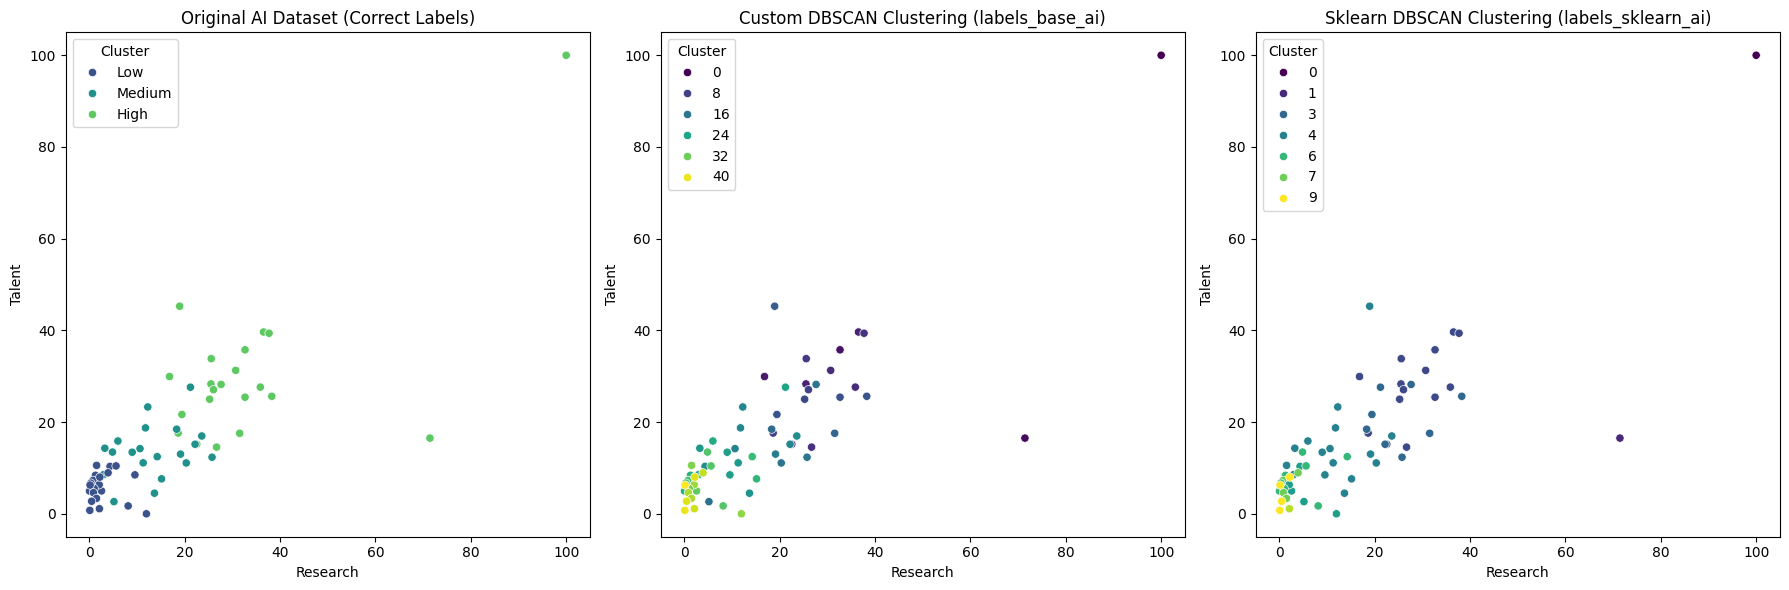

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Original Iris Dataset with Correct Labels
sns.scatterplot(data=ai, x="Research", y="Talent", hue="Total_score_Category", palette="viridis", ax=axes[0])
axes[0].set_title("Original AI Dataset (Correct Labels)")
axes[0].set_xlabel("Research")
axes[0].set_ylabel("Talent")
axes[0].legend(title="Cluster")

# Plot 2: Custom DBSCAN Labels (labels_base_ai)
sns.scatterplot(data=ai, x="Research", y="Talent", hue=labels_base_ai, palette="viridis", ax=axes[1])
axes[1].set_title("Custom DBSCAN Clustering (labels_base_ai)")
axes[1].set_xlabel("Research")
axes[1].set_ylabel("Talent")
axes[1].legend(title="Cluster")

# Plot 3: Sklearn DBSCAN Labels (labels_sklearn_ai)
sns.scatterplot(data=ai, x="Research", y="Talent", hue=labels_sklearn_ai, palette="viridis", ax=axes[2])
axes[2].set_title("Sklearn DBSCAN Clustering (labels_sklearn_ai)")
axes[2].set_xlabel("Research")
axes[2].set_ylabel("Talent")
axes[2].legend(title="Cluster")

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

## Earthquakes Dataset

In [16]:

path = kagglehub.dataset_download("shreyasur965/recent-earthquakes")
earthquakes = pd.read_csv(os.path.join(path, "earthquakes.csv"))

earthquakes = earthquakes.drop(columns=["id", "type", "title", "date", "time", "updated", "url",
                                        "detailUrl", "status", "net", "code", "ids", "sources",
                                        "types", "geometryType", "place", "placeOnly", "location", "subnational", "city",
                                        "locality", "postcode", "what3words", "timezone", "locationDetails", "continent", "country"])

earthquakes = earthquakes.dropna()
earthquakes_filtered = earthquakes.drop(columns=['alert'])

encoder = OrdinalEncoder()

categorical_cols = [col for col in earthquakes_filtered.columns if earthquakes_filtered[col].dtype not in [np.int64, np.float64]]
earthquakes_filtered[categorical_cols] = encoder.fit_transform(earthquakes_filtered[categorical_cols])

X_earth = earthquakes_filtered.to_numpy()
# k_earth = 4

print("Global Earthquake Data")

start_time = time.time()
# labels_base_earth, centroids_base_earth = k_means(X_earth, k_earth)
AffinityPropagationBase = AffinityPropagationCustom().fit(X_earth)

labels_base_earth = AffinityPropagationBase.labels_
print(labels_base_earth)
print(f"Execution time (base): {time.time() - start_time} seconds")
print_metrics(X_earth, earthquakes['alert'], labels_base_earth)

start_time = time.time()
# kmeans_earth = KMeans(n_clusters=k_earth, random_state=seed).fit(X_earth)

AffinityPropagationSklearn = AffinityPropagation().fit(X_earth)

labels_sklearn_earth = AffinityPropagationSklearn.labels_
print(labels_sklearn_earth)
print(f"\nExecution time (sklearn): {time.time() - start_time} seconds")
print_metrics(X_earth, earthquakes['alert'], labels_sklearn_earth)

100%|██████████| 214k/214k [00:00<00:00, 21.6MB/s]

Extracting files...
Global Earthquake Data


[193 194 195 196 316 197 317 318 319 320 198 199 321 322 323 324 325 326
 327 328 329 202 183 209 210 330 331 332 333 228 495  72 380 496 497 498
  85  35  34 502 503 504 505 506 507 508 509 232 510 187 178  78 511 512
  74 513 524  50 192 246 248 249 449 250 251 252 253 254 255 256 257 258
 259 450 451 452 453 260 454 455 456 457 458 459 460 461 462 261 262 263
 264 265 463 464 465 466 467 468 469 266 267 268 269 270 271 272 273 274
 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291 292
 293 294 295 296 297 298 299 300 301 302 303 304 305 306 307 308 309 310
  49 311 312 475 426 427 428 476 477 434 478 435 437 479 480 438 439 440
 481 482 441 442 443 444 445 483 446 484 485 486 448 336  52 337 341 178
 345 176 346 348 349 351 355 340 401 343 344  46 313 314 315 179 220 184
   8  22 182 487 488 425 233 234 245 489 247   0   1   2   3   5 431  10
  11 403 404  21 405 406 407 408 409 410  23  24 157 411 155 412 413 152
 414 429 429 415 416 417 418 419 420 421 422 393 22

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_affinity_propagation.py:140: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


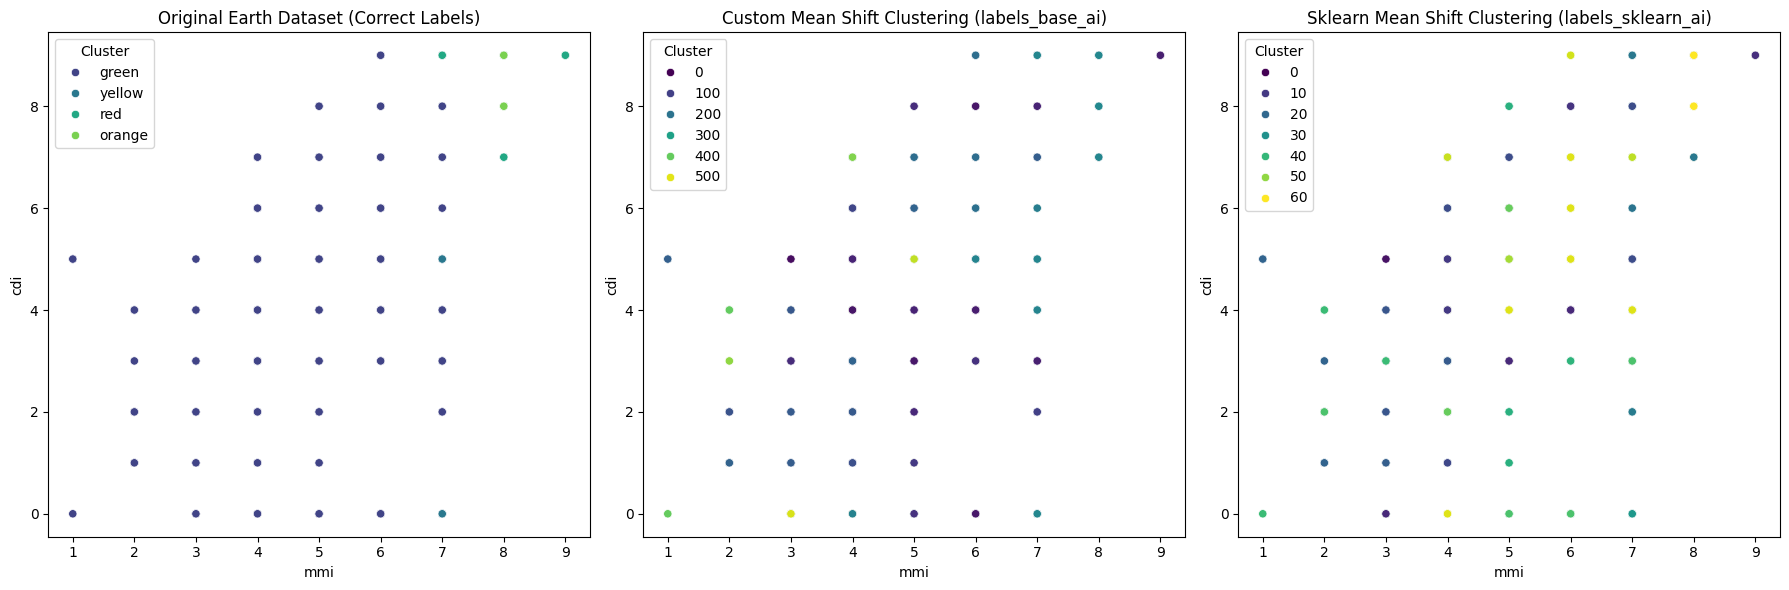

In [17]:


import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Original Iris Dataset with Correct Labels
sns.scatterplot(data=earthquakes, x="mmi", y="cdi", hue="alert", palette="viridis", ax=axes[0])
axes[0].set_title("Original Earth Dataset (Correct Labels)")
axes[0].set_xlabel("mmi")
axes[0].set_ylabel("cdi")
axes[0].legend(title="Cluster")

# Plot 2: Custom DBSCAN Labels (labels_base_ai)
sns.scatterplot(data=earthquakes, x="mmi", y="cdi", hue=labels_base_earth, palette="viridis", ax=axes[1])
axes[1].set_title("Custom Affinity Propagation Clustering (labels_base_ai)")
axes[1].set_xlabel("mmi")
axes[1].set_ylabel("cdi")
axes[1].legend(title="Cluster")

# Plot 3: Sklearn DBSCAN Labels (labels_sklearn_ai)
sns.scatterplot(data=earthquakes, x="mmi", y="cdi", hue=labels_sklearn_earth, palette="viridis", ax=axes[2])
axes[2].set_title("Sklearn Affinity Propagation Clustering (labels_sklearn_ai)")
axes[2].set_xlabel("mmi")
axes[2].set_ylabel("cdi")
axes[2].legend(title="Cluster")

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

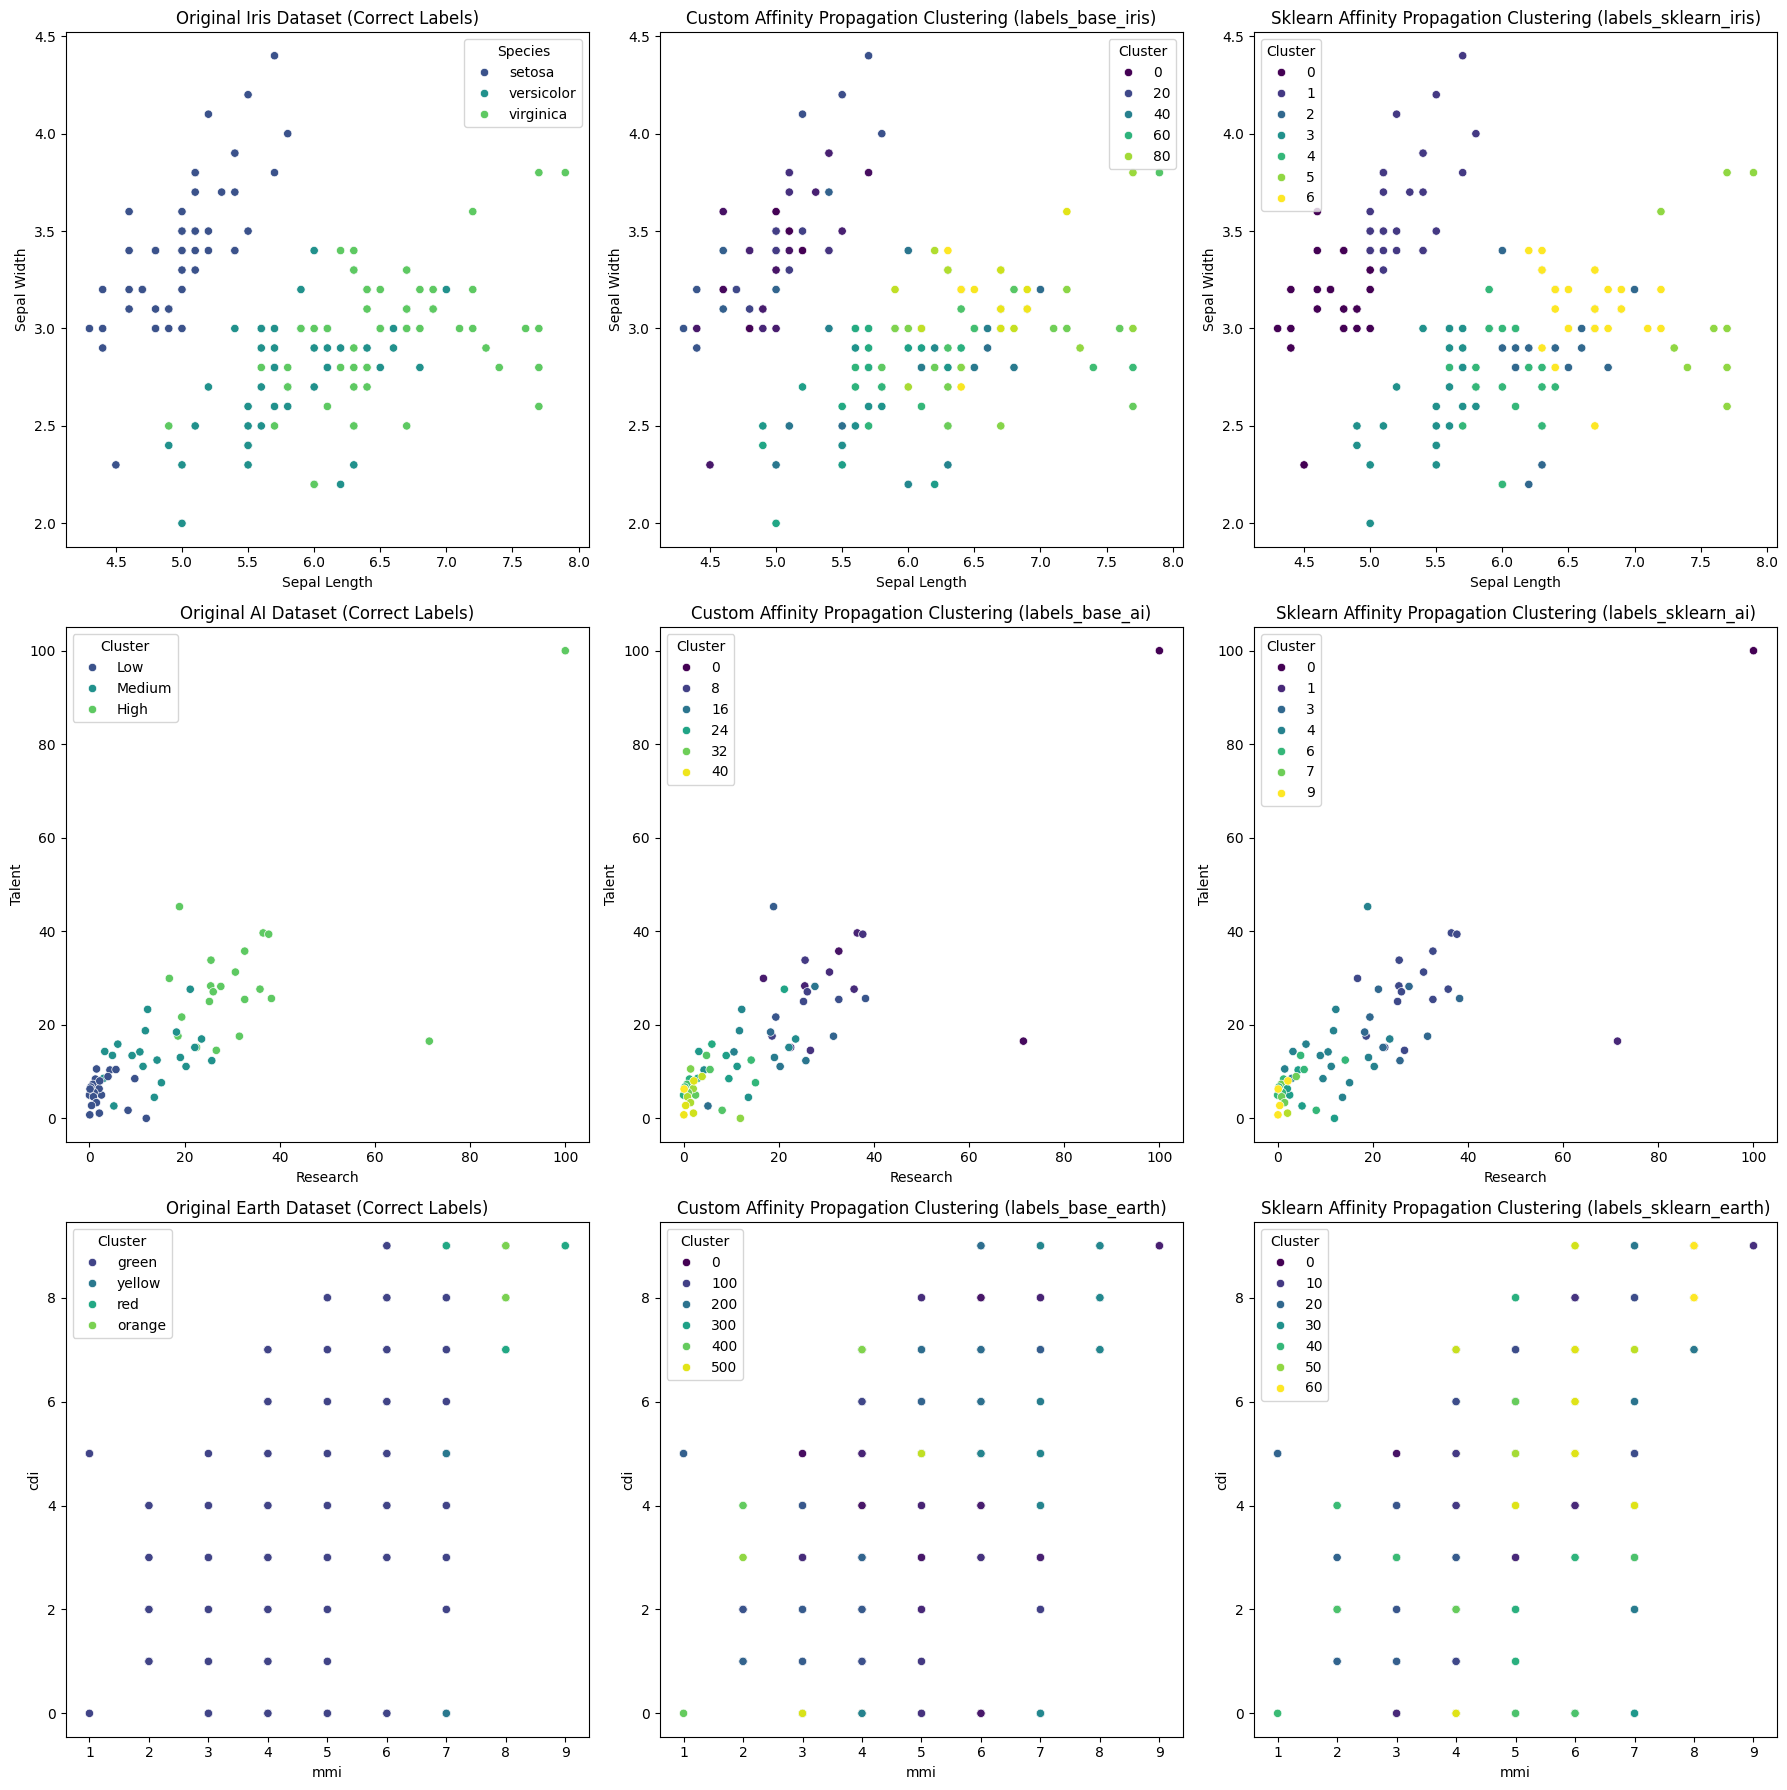

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with three subplots
fig, axes = plt.subplots(3, 3, figsize=(18, 18))

# Plot 1: Original Iris Dataset with Correct Labels
sns.scatterplot(data=iris, x="sepal_length", y="sepal_width", hue="species", palette="viridis", ax=axes[0][0])
axes[0][0].set_title("Original Iris Dataset (Correct Labels)")
axes[0][0].set_xlabel("Sepal Length")
axes[0][0].set_ylabel("Sepal Width")
axes[0][0].legend(title="Species")

# Plot 2: Custom DBSCAN Labels (labels_base_iris)
sns.scatterplot(data=iris, x="sepal_length", y="sepal_width", hue=labels_base_iris, palette="viridis", ax=axes[0][1])
axes[0][1].set_title("Custom Affinity Propagation Clustering (labels_base_iris)")
axes[0][1].set_xlabel("Sepal Length")
axes[0][1].set_ylabel("Sepal Width")
axes[0][1].legend(title="Cluster")

# Plot 3: Sklearn DBSCAN Labels (labels_sklearn_iris)
sns.scatterplot(data=iris, x="sepal_length", y="sepal_width", hue=labels_sklearn_iris, palette="viridis", ax=axes[0][2])
axes[0][2].set_title("Sklearn Affinity Propagation Clustering (labels_sklearn_iris)")
axes[0][2].set_xlabel("Sepal Length")
axes[0][2].set_ylabel("Sepal Width")
axes[0][2].legend(title="Cluster")

# Plot 1: Original Iris Dataset with Correct Labels
sns.scatterplot(data=ai, x="Research", y="Talent", hue="Total_score_Category", palette="viridis", ax=axes[1][0])
axes[1][0].set_title("Original AI Dataset (Correct Labels)")
axes[1][0].set_xlabel("Research")
axes[1][0].set_ylabel("Talent")
axes[1][0].legend(title="Cluster")

# Plot 2: Custom OPTICS Labels (labels_base_ai)
sns.scatterplot(data=ai, x="Research", y="Talent", hue=labels_base_ai, palette="viridis", ax=axes[1][1])
axes[1][1].set_title("Custom Affinity Propagation Clustering (labels_base_ai)")
axes[1][1].set_xlabel("Research")
axes[1][1].set_ylabel("Talent")
axes[1][1].legend(title="Cluster")

# Plot 3: Sklearn OPTICS Labels (labels_sklearn_ai)
sns.scatterplot(data=ai, x="Research", y="Talent", hue=labels_sklearn_ai, palette="viridis", ax=axes[1][2])
axes[1][2].set_title("Sklearn Affinity Propagation Clustering (labels_sklearn_ai)")
axes[1][2].set_xlabel("Research")
axes[1][2].set_ylabel("Talent")
axes[1][2].legend(title="Cluster")


# Plot 1: Original Iris Dataset with Correct Labels
sns.scatterplot(data=earthquakes, x="mmi", y="cdi", hue="alert", palette="viridis", ax=axes[2][0])
axes[2][0].set_title("Original Earth Dataset (Correct Labels)")
axes[2][0].set_xlabel("mmi")
axes[2][0].set_ylabel("cdi")
axes[2][0].legend(title="Cluster")

# Plot 2: Custom DBSCAN Labels (labels_base_ai)
sns.scatterplot(data=earthquakes, x="mmi", y="cdi", hue=labels_base_earth, palette="viridis", ax=axes[2][1])
axes[2][1].set_title("Custom Affinity Propagation Clustering (labels_base_earth)")
axes[2][1].set_xlabel("mmi")
axes[2][1].set_ylabel("cdi")
axes[2][1].legend(title="Cluster")

# Plot 3: Sklearn DBSCAN Labels (labels_sklearn_ai)
sns.scatterplot(data=earthquakes, x="mmi", y="cdi", hue=labels_sklearn_earth, palette="viridis", ax=axes[2][2])
axes[2][2].set_title("Sklearn Affinity Propagation Clustering (labels_sklearn_earth)")
axes[2][2].set_xlabel("mmi")
axes[2][2].set_ylabel("cdi")
axes[2][2].legend(title="Cluster")

# Adjust layout and display the plot
plt.tight_layout()
plt.show()